__Structural Estimation__ <br>
Problem Set 2 <br>
January 23, 2019 <br>
Ginha Kim <br>

In [1]:
# Import libraries
import numpy as np
import scipy.stats as sts
import scipy.integrate as integ
import scipy.optimize as opt
from scipy.stats import beta
import scipy.special as spc
import requests
import sys
from ipykernel import kernelapp as app


# Problem 1
Health claim amounts and GB family of distributions

In [2]:
# Load data
url = ('https://raw.githubusercontent.com/rickecon/StructEst_W19/'
       +'master/ProblemSets/PS2/clms.txt')
data_file = requests.get(url,allow_redirects=True)
open('clms.txt','wb').write(data_file.content)
clms = np.loadtxt('clms.txt')

## (a) Descriptive Statistics & Histogram

In [4]:
# Calculate Descriptive Statistics
mean_clms = np.mean(clms)
med_clms  = np.median(clms)
std_clms  = np.std(clms)
max_clms  = np.max(clms)
min_clms  = np.min(clms)
print('Health claims ($)')
print('Mean: ',mean_clms)
print('Median: ',med_clms)
print('Standard Deviation: ',std_clms)
print('Maximum: ',max_clms)
print('Minimum: ',min_clms)

Health claims ($)
Mean:  720.277975327
Median:  172.21
Standard Deviation:  3972.66375639
Maximum:  227967.25
Minimum:  0.01


<IPython.core.display.Javascript object>


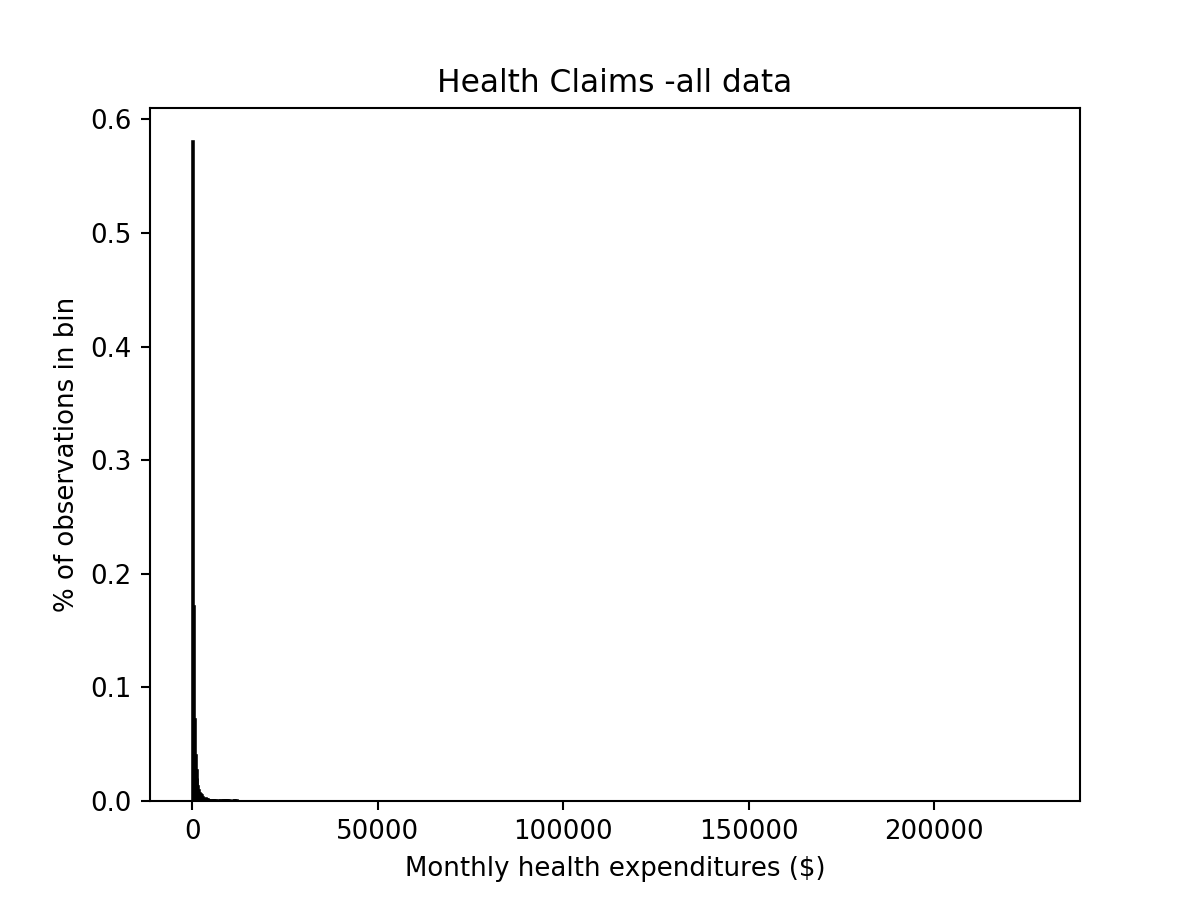

Sum of heights of the histogram bars:  1.0


In [6]:
# First histogram for all the observations
import matplotlib.pyplot as plt
%matplotlib notebook
weights= (1/clms.shape[0])*np.ones_like(clms)
n, bins, patches = plt.hist(clms,1000,weights=weights,edgecolor ='k',facecolor='green',stacked=True)
plt.title('Health Claims -all data')
plt.xlabel('Monthly health expenditures ($)')
plt.ylabel('% of observations in bin')
print('Sum of heights of the histogram bars: ',n.sum())

<IPython.core.display.Javascript object>


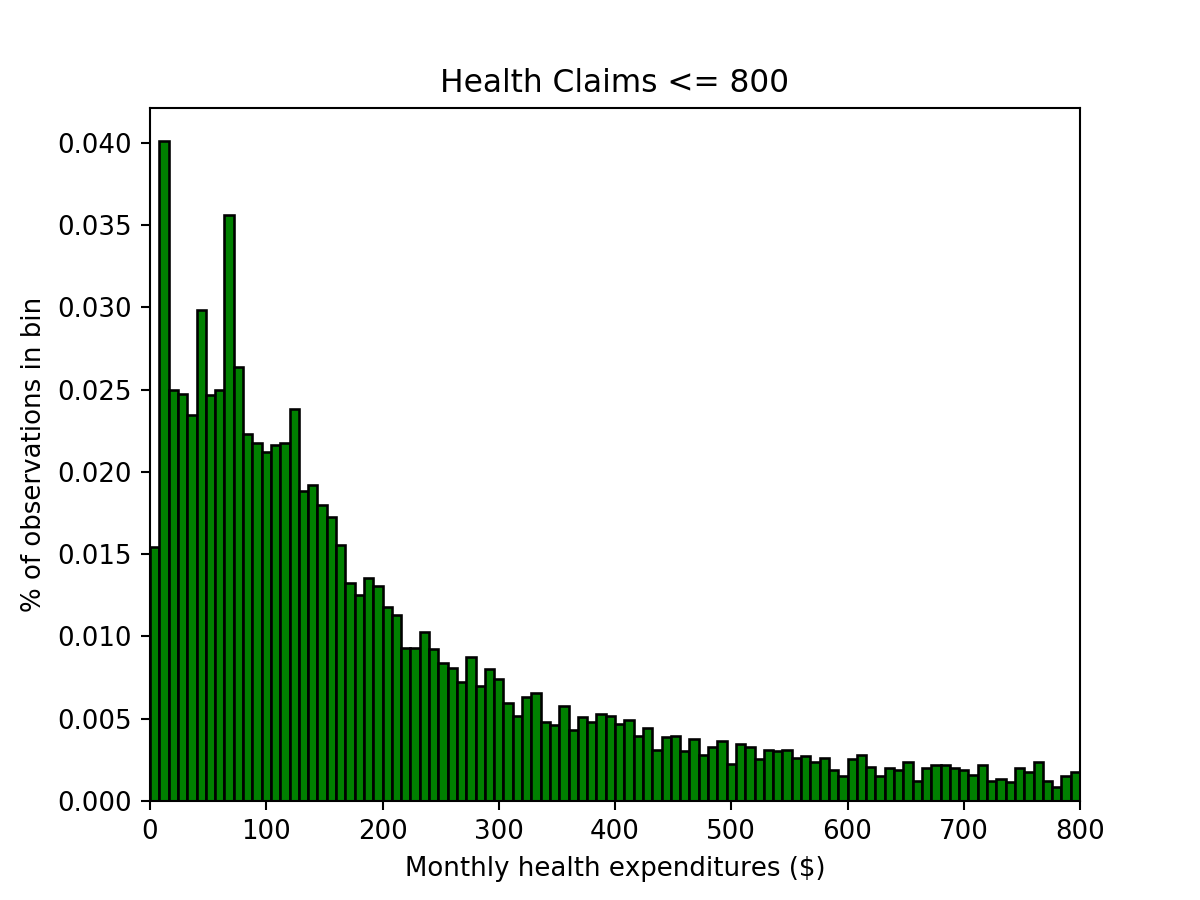

Sum of heights of the histogram bars:  0.849420849421


In [7]:
# Second histogram for observations less than 800
weights= (1/clms.shape[0])*np.ones_like(clms)
n, bins, patches = plt.hist(clms,100,range=(0,800),weights=weights,edgecolor ='k',facecolor='green',stacked=False)
plt.title('Health Claims <= 800')
plt.xlabel(r'Monthly health expenditures ($)')
plt.ylabel(r'% of observations in bin')
plt.xlim([0,800])
print('Sum of heights of the histogram bars: ',n.sum())

We may prefer the second histogram because it puts focus on the interval that contains a majority of observations. We see in the data that the standard deviation of observations is high, and there are a few outliers with very high values such that the first histrogram plotted over the whole range is not so informative.

## (b) MLE - Gamma

alpha_mle =  0.221755309875
beta_mle =  21911.0646993
Maximum Log-likelihood:  -82076.4516057


<IPython.core.display.Javascript object>


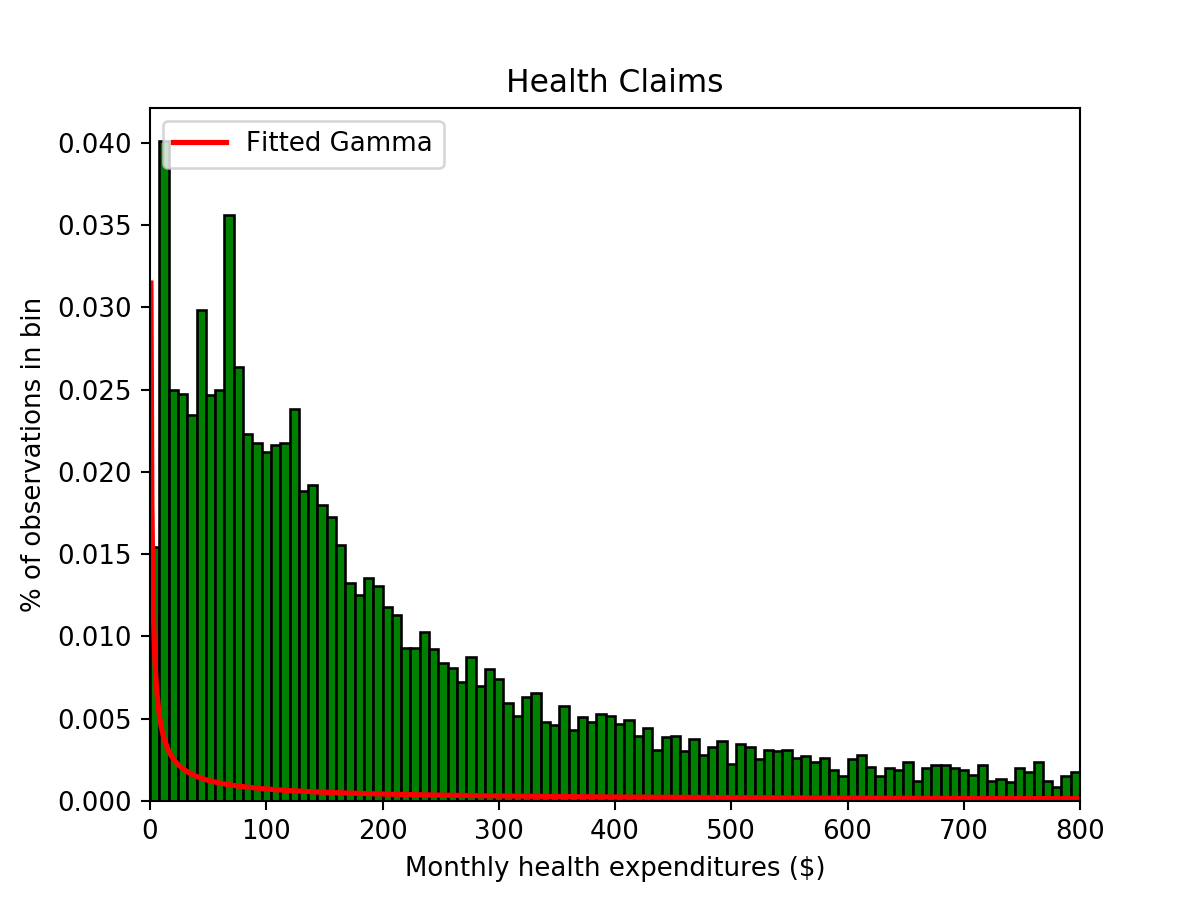

C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
# Define probability density function
def gamma_pdf(xvals, alpha, beta):
    pdf_vals = (1/((beta**alpha) * spc.gamma(alpha))) * (xvals**(alpha-1)) * np.exp(-(xvals/beta))
    return pdf_vals

# Define log-likelihood function
def log_like_gamma(xvals,alpha,beta):
    pdf_vals = gamma_pdf(xvals,alpha,beta)
    ln_pdf_vals = np.log(pdf_vals)
    log_like_val = ln_pdf_vals.sum()
    return log_like_val

# Define criterion function
def crit(params,*args):
    alpha,beta = params
    xvals = args
    log_like_val = log_like_gamma(xvals,alpha,beta)
    neg_log_like_val = -(log_like_val)
    return neg_log_like_val

# MLE
beta_0   = (std_clms)**2/mean_clms
alpha_0  = mean_clms/beta_0
params_0 = np.array([alpha_0,beta_0])
xvals    = clms
results  = opt.minimize(crit,params_0,args=xvals,method='L-BFGS-B',
                        bounds=((1e-10,None),(1e-10,None)))
alpha_mle_b,beta_mle_b = results.x
log_like_ga = log_like_gamma(clms,alpha_mle_b,beta_mle_b)
print('alpha_mle = ',alpha_mle_b)
print('beta_mle = ',beta_mle_b)
print('Maximum Log-likelihood: ',log_like_gamma(clms,alpha_mle_b,beta_mle_b))

# Plot line over histogram
weights= (1/clms.shape[0])*np.ones_like(clms)
n, bins, patches = plt.hist(clms,100,range=(0,800),weights=weights,edgecolor ='k',facecolor='green',stacked=False)
plt.title('Health Claims')
plt.xlabel(r'Monthly health expenditures ($)')
plt.ylabel(r'% of observations in bin')
plt.xlim([0,800])
dist_clms = np.linspace(0,800,1000)
plt.plot(dist_clms,gamma_pdf(dist_clms,alpha_mle_b,beta_mle_b),
         linewidth=2,color='r',label='Fitted Gamma')
plt.legend(loc='upper left')
plt.show()

## (c) MLE - Generalized Gamma

alpha_mle =  0.221751913854
beta_mle =  21911.0644298
m_mle =  0.997019423793
Maximum Log-likelihood:  -82076.4468421


<IPython.core.display.Javascript object>


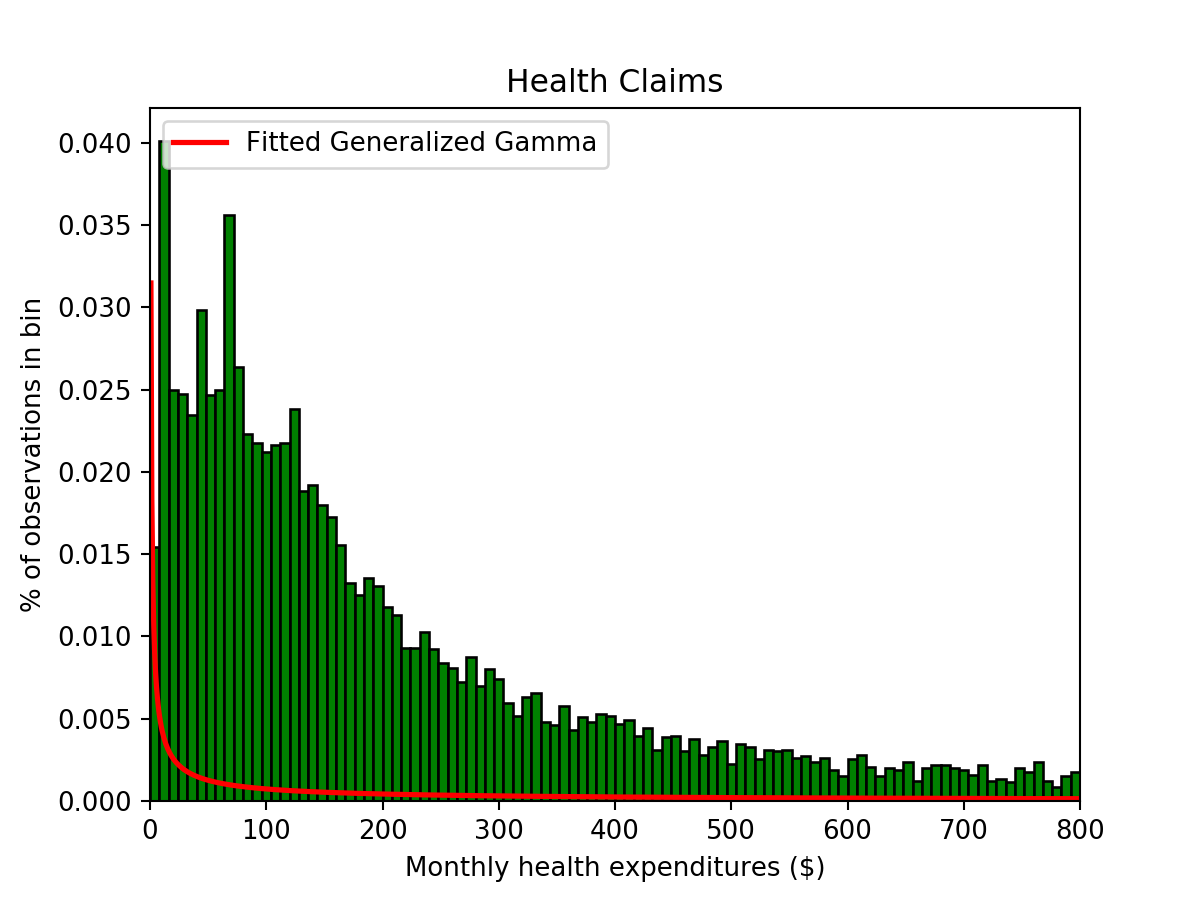

C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
# Define probability density function
def gengamma_pdf(xvals, alpha, beta, m):
    pdf_vals = m*xvals**(alpha-1)*(np.exp(-(xvals/beta)**m)/(spc.gamma(alpha/m)*beta**alpha)) 
    return pdf_vals

# Define log-likelihood function
def log_like_gengamma(xvals,alpha,beta,m):
    pdf_vals = gengamma_pdf(xvals,alpha,beta,m)
    ln_pdf_vals = np.log(pdf_vals)
    log_like_val = ln_pdf_vals.sum()
    return log_like_val

# Define criterion function
def crit(params,args):
    alpha,beta,m = params
    xvals = args
    log_like_val = log_like_gengamma(xvals,alpha,beta,m)
    neg_log_like_val = -(log_like_val)
    return neg_log_like_val

# MLE
beta_0   = beta_mle_b
alpha_0  = alpha_mle_b
m_0      = 1
params_0 = np.array([alpha_0,beta_0,m_0])
xvals    = clms
results_c  = opt.minimize(crit,params_0,args=xvals,method='L-BFGS-B',
                        bounds=((1e-10,None),(1e-10,None),(1e-10,None)))
alpha_mle_c,beta_mle_c,m_mle_c = results_c.x
log_like_gg = log_like_gengamma(clms,alpha_mle_c,beta_mle_c,m_mle_c)

print('alpha_mle = ',alpha_mle_c)
print('beta_mle = ',beta_mle_c)
print('m_mle = ',m_mle_c)
print('Maximum Log-likelihood: ',log_like_gengamma(clms,alpha_mle_c,beta_mle_c,m_mle_c))

# Plot line over histogram
weights= (1/clms.shape[0])*np.ones_like(clms)
n, bins, patches = plt.hist(clms,100,range=(0,800),weights=weights,edgecolor ='k',facecolor='green',stacked=False)
plt.title('Health Claims')
plt.xlabel(r'Monthly health expenditures ($)')
plt.ylabel(r'% of observations in bin')
plt.xlim([0,800])
dist_clms = np.linspace(0,800,1000)
plt.plot(dist_clms,gengamma_pdf(dist_clms,alpha_mle_c,beta_mle_c,m_mle_c),
         linewidth=2,color='r',label='Fitted Generalized Gamma')
plt.legend(loc='upper left')
plt.show()

## (d) MLE - Generalized Beta 2

alpha_mle =  0.699146997495
beta_mle =  225227503.146
p_mle =  0.995471853578
q_mle =  9998.52757625
Maximum Log-likelihood:  -76459.7641191


<IPython.core.display.Javascript object>


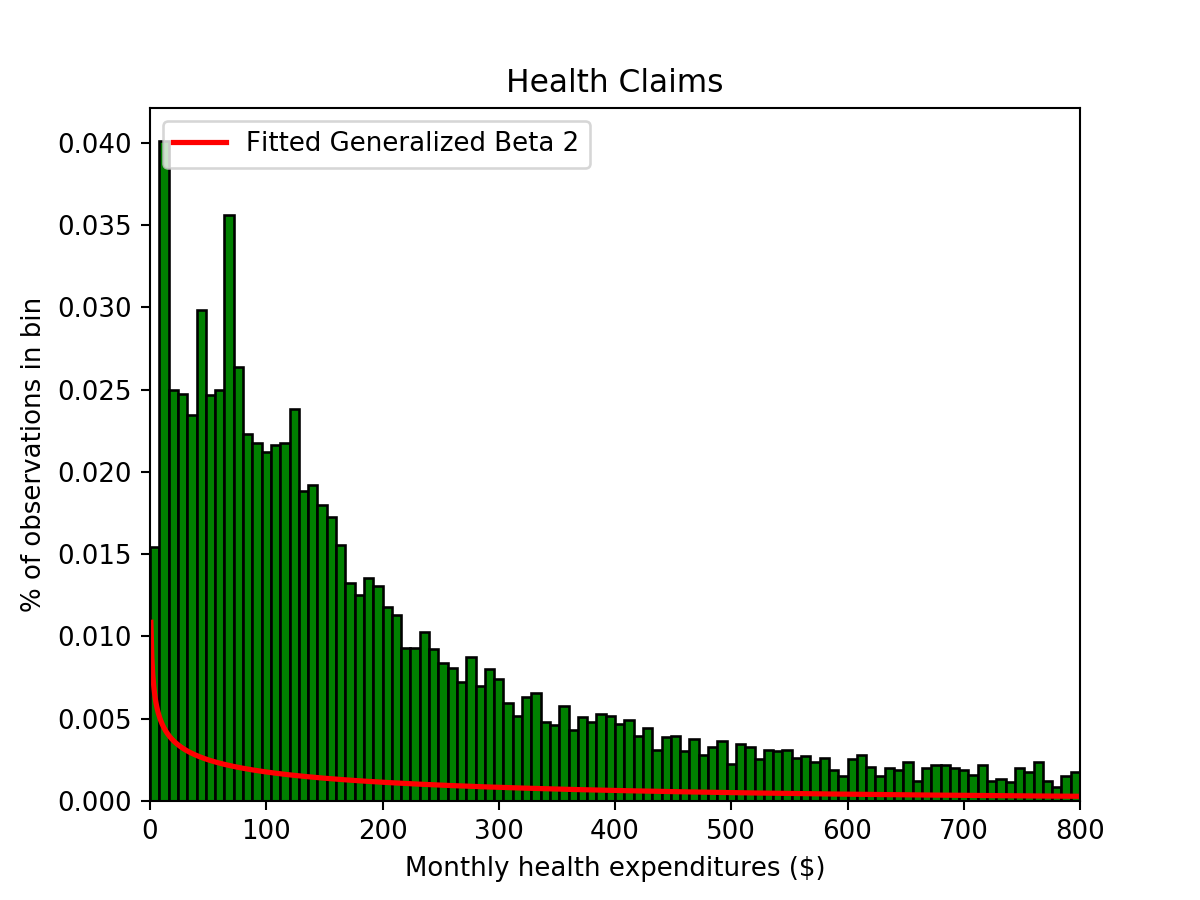

C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
# Define probability density function
def gb2_pdf(xvals,a,b,p,q):
    pdf_vals = a*xvals**(a*p-1)/(b**(a*p)*(1+(xvals/b)**a)**(p+q)*spc.beta(p,q))
    return pdf_vals

# Define log-likelihood function
def log_like_gb2(xvals,a,b,p,q):
    pdf_vals = gb2_pdf(xvals,a,b,p,q)
    ln_pdf_vals = np.log(pdf_vals) 
    log_like_val = ln_pdf_vals.sum()
    return log_like_val

# Define criterion function
def crit_gb2(params, args):
    a, b, p, q = params
    xvals = args
    log_like_val = log_like_gb2(xvals,a,b,p,q)
    neg_log_like_val = -(log_like_val)
    return neg_log_like_val

# MLE
a_0 = m_mle_c
q_0 = 10000
b_0 = (q_0**(1/a_0))*beta_mle_c
p_0 = alpha_mle_c/m_mle_c
params_0 = np.array([a_0,b_0,p_0,q_0])
params_bounds = ((1e-10,None),(1e-10,None),(1e-10,None),(1e-10,None))
xvals    = clms
results  = opt.minimize(crit_gb2,params_0,args=xvals,method='L-BFGS-B',
                        bounds=params_bounds)
alpha_mle_d,beta_mle_d,p_mle_d,q_mle_d = results.x
log_like_gb = log_like_gb2(clms,alpha_mle_d,beta_mle_d,p_mle_d,q_mle_d)

print('alpha_mle = ',alpha_mle_d)
print('beta_mle = ',beta_mle_d)
print('p_mle = ',p_mle_d)
print('q_mle = ',q_mle_d)
print('Maximum Log-likelihood: ',log_like_gb2(clms,alpha_mle_d,beta_mle_d,p_mle_d,q_mle_d))

# Plot line over histogram
weights= (1/clms.shape[0])*np.ones_like(clms)
n, bins, patches = plt.hist(clms,100,range=(0,800),weights=weights,edgecolor ='k',facecolor='green',stacked=False)
plt.title('Health Claims')
plt.xlabel(r'Monthly health expenditures ($)')
plt.ylabel(r'% of observations in bin')
plt.xlim([0,800])
dist_clms = np.linspace(0,800,1000)
plt.plot(dist_clms,gb2_pdf(dist_clms,alpha_mle_d,beta_mle_d,p_mle_d,q_mle_d),
         linewidth=2,color='r',label='Fitted Generalized Beta 2')
plt.legend(loc='upper left')
plt.show()

## (e) Likelihood Ratio Test

In [11]:
# Compute Likelihood Ratio Statistics
lr_ga = 2*(log_like_gb - log_like_ga)
lr_gg = 2*(log_like_gb - log_like_gg)

print('Likelihood Ratio Test Statistic for gamma = ',lr_ga)
print('Likelihood Ratio Test Statistic for gen. gamma = ',lr_gg)

# Compute associated p-values
pval_ga = 1.0 - sts.chi2.cdf(lr_ga,4)
pval_gg = 1.0 - sts.chi2.cdf(lr_gg,4)

print('chi-squared of H0 with 4 degrees of freedom p-value for gamma = ',pval_ga)
print('chi-squared of H0 with 4 degrees of freedom p-value for gen. gamma = ',pval_gg)

Likelihood Ratio Test Statistic for gamma =  11233.3749732
Likelihood Ratio Test Statistic for gen. gamma =  11233.3654462
chi-squared of H0 with 4 degrees of freedom p-value for gamma =  0.0
chi-squared of H0 with 4 degrees of freedom p-value for gen. gamma =  0.0


## (f) Likelihood Estimation

In [12]:
prob_gb2 =  round(1 - integ.quad(lambda x: gb2_pdf(x, alpha_mle_d, beta_mle_d, p_mle_d, q_mle_d), 0, 1000)[0],5)
prob_ga  = round(1 - integ.quad(lambda x: gamma_pdf(x, alpha_mle_b, beta_mle_b), 0, 1000)[0],5)
print('probability of health care claim over $1000 gen. beta 2 = ',prob_gb2)
print('probability of health care claim over $1000 gamma = ',prob_ga)

probability of health care claim over $1000 gen. beta 2 =  0.16253
probability of health care claim over $1000 gamma =  0.45196


# Problem 2
MLE estimation of a simple macroeconomic model with data on $(c_t,k_t,w_t,r_t)$

\begin{align}
& (c_t)^{-1} - \beta E[r_{t+1}(c_{t+1})^{-1}]  & = 0 & \qquad (1)\\
& c_t + k_{t+1} - w_t -r_tk_t  & = 0 & \qquad (2)\\
& w_t-(1-\alpha)e^{z_t}(k_t)^\alpha  & = 0 & \qquad (3)\\
& r_t - \alpha e^{z_t}(k_t)^{\alpha-1} & = 0 & \qquad (4)\\
& \rho z_{t-1} + (1-\rho)\mu +\epsilon_t & = z_t  & \qquad (5) \\
& \qquad \quad \quad \text{   where  } \epsilon_t \sim N(0,\sigma^2)\\
\end{align}
<br>
Estimate $(\alpha,\beta,\rho,\mu,\sigma)$ under the following constraints


\begin{align}
& \alpha,\beta \in (0,1), & \mu,\sigma > 0, & \quad \rho \in (-1,1)
\end{align}

In [13]:
# Load Data
import pandas as pd
data = pd.read_csv('MacroSeries.txt',sep=',',header=None,names = ['cons','save','wage','ror'])

## (a)

In [14]:
c = data['cons']
# from equation (3)
def get_zt(w,k,alpha):
    z =  np.log(w)-np.log(1-alpha)-alpha*np.log(k)
    return z

# from equation (5)
def get_ep(z,rho,mu):
    ep = np.zeros(len(c))
    ep[0] = z[0] - mu
    for i in range(len(c)-1):
        ep[i+1] = z[i+1] - rho*z[i] -(1-rho)*mu       
    return ep

# Define functions for MLE
def norm_pdf(w,k,alpha,rho,mu,sigma):
    z = get_zt(w,k,alpha)
    ep = get_ep(z,rho,mu)
    pdf_vals = np.maximum((1/np.sqrt(2*np.pi*(sigma**2))) * np.exp(-(ep**2)/(2*(sigma**2))), 1e-20)
    return pdf_vals

def log_like_norm(w,k,alpha,rho,mu,sigma):
    pdf_vals = norm_pdf(w,k,alpha,rho,mu,sigma)
    ln_pdf_vals = np.log(pdf_vals)
    log_like_val = ln_pdf_vals.sum()
    return log_like_val

def crit(params,*args):
    alpha, rho, mu, sigma = params
    w, k = args
    log_like_val = log_like_norm(w,k,alpha,rho,mu,sigma)
    neg_log_like_val = -log_like_val
    
    return neg_log_like_val

alpha_0 = 0.512
rho_0 = 0.512
mu_0 = 9.12
sigma_0 = 0.1512
params_0 = np.array([alpha_0,rho_0,mu_0,sigma_0])
params_bounds = ((1e-10,1-1e-10),(1e-10,1-1e-10),(1e-10,None),(1e-10,None))
xvals    = data['wage'], data['save']
results  = opt.minimize(crit,params_0,args=xvals,method='L-BFGS-B',
                        bounds=params_bounds)
alpha_mle_a,rho_mle_a,mu_mle_a,sigma_mle_a = results.x
log_like_a = log_like_norm(data['wage'],data['save'],alpha_mle_a,rho_mle_a,mu_mle_a,sigma_mle_a)
Hessian_inv = results.hess_inv.todense()
print('alpha_mle = ',alpha_mle_a)
print('rho_mle = ',rho_mle_a)
print('mu_mle = ',mu_mle_a)
print('sigma_mle = ',sigma_mle_a)
print('Maximum Log-likelihood: ',log_like_a)
print('Inverse Hessian Matrix = ')
print(Hessian_inv)

alpha_mle =  0.487347178373
rho_mle =  0.697852152926
mu_mle =  9.10721185745
sigma_mle =  0.092003111107
Maximum Log-likelihood:  96.6993353587
Inverse Hessian Matrix = 
[[  9.65577043e-03  -7.13422755e-01  -2.81272277e-02   4.38209682e-04]
 [ -7.13422755e-01   2.01780877e+02  -1.20141564e+01   3.56130369e+00]
 [ -2.81272277e-02  -1.20141564e+01   1.71379358e+00  -2.10783134e-01]
 [  4.38209682e-04   3.56130369e+00  -2.10783134e-01   1.43427480e-01]]


## (b)

In [15]:
c = data['cons']
# from equation (4)
def get_zb(k,r,alpha):
    z =  np.log(r)-np.log(alpha)-(alpha-1)*np.log(k)
    return z

# from equation (5)
def get_epb(z,rho,mu):
    ep = np.zeros(len(c))
    ep[0] = z[0] - mu
    for i in range(len(c)-1):
        ep[i+1] = z[i+1] - rho*z[i] -(1-rho)*mu       
    return ep

# Define functions for MLE
def norm_pdf(k,r,alpha,rho,mu,sigma):
    z = get_zb(k,r,alpha)
    ep = get_epb(z,rho,mu)
    pdf_vals = np.maximum((1/np.sqrt(2*np.pi*(sigma**2))) * np.exp(-(ep**2)/(2*(sigma**2))), 1e-20)
    return pdf_vals

def log_like_norm(k,r,alpha,rho,mu,sigma):
    pdf_vals = norm_pdf(k,r,alpha,rho,mu,sigma)
    ln_pdf_vals = np.log(pdf_vals)
    log_like_val = ln_pdf_vals.sum()
    return log_like_val

def crit(params,*args):
    alpha, rho, mu, sigma = params
    k, r = args
    log_like_val = log_like_norm(k,r,alpha,rho,mu,sigma)
    neg_log_like_val = -log_like_val
    
    return neg_log_like_val

alpha_0 = 0.512
rho_0 = 0.512
mu_0 = 9.12
sigma_0 = 0.1512
params_0 = np.array([alpha_0,rho_0,mu_0,sigma_0])
params_bounds = ((1e-10,1-1e-10),(1e-10,1-1e-10),(1e-10,None),(1e-10,None))
xvals    = data['save'], data['ror']
results  = opt.minimize(crit,params_0,args=xvals,method='L-BFGS-B',
                        bounds=params_bounds)
alpha_mle_b,rho_mle_b,mu_mle_b,sigma_mle_b = results.x
log_like_b = log_like_norm(data['save'],data['ror'],alpha_mle_b,rho_mle_b,mu_mle_b,sigma_mle_b)
Hessian_inv = results.hess_inv.todense()
print('alpha_mle = ',alpha_mle_b)
print('rho_mle = ',rho_mle_b)
print('mu_mle = ',mu_mle_b)
print('sigma_mle = ',sigma_mle_b)
print('Maximum Log-likelihood: ',log_like_b)
print('Inverse Hessian Matrix = ')
print(Hessian_inv)

alpha_mle =  0.471755211984
rho_mle =  0.709935995348
mu_mle =  9.11430346535
sigma_mle =  0.0919978784865
Maximum Log-likelihood:  96.7050288309
Inverse Hessian Matrix = 
[[  0.05313447   1.26197133  -0.1096893   -0.23287946]
 [  1.26197133  32.14838431  -1.31917266  -5.89737163]
 [ -0.1096893   -1.31917266   1.05345911   0.25187522]
 [ -0.23287946  -5.89737163   0.25187522   1.08472548]]


## (c)

In [17]:
k_curr = 7500000
r_curr = 1
z_prev = 10
z_star = get_zb(k_curr,r_curr,alpha_mle_a)
prob = 1-sts.norm.cdf(z_star,loc=rho_mle_a*z_prev+(1-rho_mle_a)*mu_mle_a,scale=sigma_mle_a)
print('conditional probability that r_t > 1 = ',prob)

conditional probability that r_t > 1 =  1.0
